![Nuclio logo](https://nuclio.school/wp-content/uploads/2018/12/nucleoDS-newBlack.png)

## 1. Librerias

Para empezar carguemos esas librerias que nos hacen falta

In [1]:
from tensorflow import keras as ks
from matplotlib import pyplot as plt
import numpy as np
import time
import datetime
import tensorflow as tf

from keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input, Conv2D, MaxPooling2D
from keras.optimizers import Adam

from tensorflow.keras.callbacks import EarlyStopping
from keras.api._v2.keras import callbacks

In [2]:
## Loading Dataset
cifar10 = ks.datasets.cifar10

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

170498071/170498071 [==============================] - 6s 0us/step


In [3]:
## Checking loaded cata

print("Train samples:" , x_train.shape, y_train.shape)
print("Test samples:" ,x_test.shape, y_test.shape)

Train samples: (50000, 32, 32, 3) (50000, 1)
Test samples: (10000, 32, 32, 3) (10000, 1)


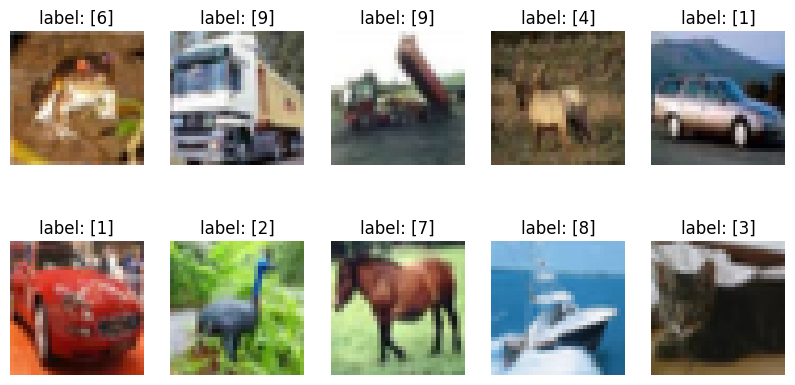

In [4]:
## Show images

plt.figure(figsize=(10,5))

for i in range(10):
  plt.subplot(2,5,i+1)
  plt.axis('off')
  plt.title('label: '+str(y_train[i]))
  plt.imshow(x_train[i])

## Preprocessing data

In [5]:
y_train_label = y_train

# One hot encoder
y_test = ks.utils.to_categorical(y_test)
y_train = ks.utils.to_categorical(y_train)

y_test
y_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]], dtype=float32)

In [6]:
#Data Normalization
x_train, x_test = x_train / 255.0, x_test / 255.0
#y_train, y_test = y_train.flatten(), y_test.flatten()

In [7]:
## Training and validation data division

x_train1, x_val, y_train1, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

## 2. Arquitectura de red del modelo


In [8]:
model = Sequential()

model.add(Conv2D(64, (3,3), strides=(1,1), padding='same', activation='relu', input_shape = (32,32,3)))
model.add(Conv2D(128, (3,3), strides=(1,1), padding='same', activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.3))
model.add(Conv2D(128, (3,3), strides=(1,1), padding='same', activation='relu'))
model.add(Dropout(0.3))
model.add(Conv2D(256, (3,3), strides=(1,1), padding='same', activation='relu'))
model.add(Conv2D(256, (3,3), strides=(1,1), padding='same', activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(512, activation = 'relu'))
model.add(Dropout(0.8))
model.add(Dense(10, activation = 'softmax'))


Para revisar un modelo, nos basta con llamar al método **.summary()** del modelo

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 128)       73856     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 128)      0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 16, 16, 128)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 128)       147584    
                                                                 
 dropout_1 (Dropout)         (None, 16, 16, 128)       0         
                                                        

## 3. Optimizador, función error


In [10]:
#model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              #loss=tf.keras.losses.CategoricalCrossentropy(),


In [11]:
# Define el learning rate deseado
learning_rate = 0.0001

# Compila el modelo con el optimizador 'Adam' y el nuevo learning rate
model.compile(optimizer=Adam(learning_rate=learning_rate),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


## 4. Preparamos los datos

Cargamos los datos de CIFAR10 de los datasets directamente de las librerias de Keras. Estos ya estan dispuestos en train and test

**Detalle importante:**
> La red neuronal requiere que los inputs sean números reales, y lo haremos forzando la division de los valores de dentro de las matrices 28x28 (que tienen valoress del 0 al 255) por 255.0 (un real)

Obtenemos un array con todas las labels de CIFAR10

In [12]:
cifar10_labels = [
'airplane', # id 0
'automobile',
'bird',
'cat',
'deer',
'dog',
'frog',
'horse',
'ship',
'truck',
]

print('Number of labels: %s' % len(cifar10_labels))

Number of labels: 10


Pintemos una muestra de las imagenes del dataset CIFAR10, a ver si se parece en algo a lo que esperamos.
Primero, vemos que tipos de datos tengo, después mapeamos esas matrices en una escala de grises utilizando el método **.get_cmap()** de PlotLy con los nueve primeros números del dataset.

Train: X=(50000, 32, 32, 3), y=(50000, 10)
Test: X=(10000, 32, 32, 3), y=(10000, 10)


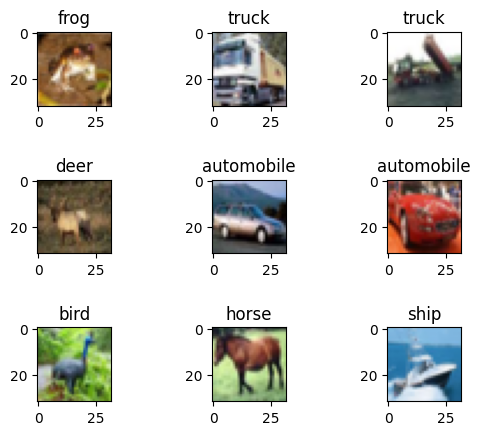

In [13]:
# Pintemos una muestra de las las imagenes del dataset MNIST

print('Train: X=%s, y=%s' % (x_train.shape, y_train.shape))
print('Test: X=%s, y=%s' % (x_test.shape, y_test.shape))

for i in range(9):

    plt.subplot(330 + 1 + i)
    plt.imshow(x_train[i], cmap=plt.get_cmap('gray'))
    plt.title(cifar10_labels[y_train_label[i,0]])

plt.subplots_adjust(hspace = 1)
plt.show()

Como vamos a querer ir haciendo validación a la vez que entrenamos (muy practico)

In [14]:
#x_val = x_train[-10000:]
#y_val = y_train[-10000:]

#x_train = x_train[:-10000]
#y_train = y_train[:-10000]


Cuando añadimos convoluciones, necesitamos "pre-tratar los datos", porque **la convolución espera una matriz de 4 campos** (más parecido a "imagenes"), en el caso de MNIST. CIFAR10 ya tiene el shape adecuado, así que no tenemos que hacer nada, pero como siempre decimos: es mejor que comprobeis su tamaño.

Por eso, al salir de la Convolution, hay que hacer un Flatten, porque las capas FullDense esperan arrays, no matrices!!

Luego lo imprimimos para ver que todo está correcto

In [15]:
# Validamos el resultado
print('Train: X=%s, y=%s' % (x_train.shape, y_train.shape))
print('Test: X=%s, y=%s' % (x_test.shape, y_test.shape))
print('Validation: X=%s, y=%s' % (x_val.shape, y_val.shape))

Train: X=(50000, 32, 32, 3), y=(50000, 10)
Test: X=(10000, 32, 32, 3), y=(10000, 10)
Validation: X=(10000, 32, 32, 3), y=(10000, 10)


## 5. Entrenamiento

Ya podemos ponernos a entrenar el modelo!! Ojo, que hemos de entrenar contra los datos convertidos al formato que espera la Convolution.

Empezaremos con 30 epocs, es decir, 30 pasadas completas del dataset (que a su vez sera con mini-batches internamente), fijando un batch de 64

El metodo .fit() nos permite, definir además si disponemos de varias CPUs, GPUs, y si queremos ir validando datos a cada fin de epoch.

In [16]:
print(np.shape(y_train1))
print(np.shape(y_val))


(40000, 10)
(10000, 10)


In [17]:
t = time.perf_counter()

In [18]:
y_train1 = np.argmax(y_train1, axis=1)
y_val = np.argmax(y_val, axis=1)


In [19]:
#Aumento el Early Stopping al modelo
callback_loss = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=True)
callback_acc = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True, baseline=0.5, verbose=True)

In [20]:
history = model.fit(x_train1, y_train1, epochs=150,
                    batch_size= 128,
                    use_multiprocessing=False,
                    validation_data=(x_val, y_val),
                    callbacks=[callback_acc])

Epoch 1/150
313/313 [==============================] - 29s 58ms/step - loss: 2.0081 - accuracy: 0.2547 - val_loss: 1.6390 - val_accuracy: 0.3981
Epoch 2/150
313/313 [==============================] - 17s 54ms/step - loss: 1.6454 - accuracy: 0.4000 - val_loss: 1.4098 - val_accuracy: 0.4867
Epoch 3/150
313/313 [==============================] - 17s 54ms/step - loss: 1.4588 - accuracy: 0.4772 - val_loss: 1.2421 - val_accuracy: 0.5545
Epoch 4/150
313/313 [==============================] - 17s 55ms/step - loss: 1.3410 - accuracy: 0.5204 - val_loss: 1.1637 - val_accuracy: 0.5858
Epoch 5/150
313/313 [==============================] - 18s 56ms/step - loss: 1.2466 - accuracy: 0.5591 - val_loss: 1.0760 - val_accuracy: 0.6230
Epoch 6/150
313/313 [==============================] - 17s 55ms/step - loss: 1.1821 - accuracy: 0.5828 - val_loss: 1.0407 - val_accuracy: 0.6368
Epoch 7/150
313/313 [==============================] - 17s 56ms/step - loss: 1.1273 - accuracy: 0.6053 - val_loss: 0.9704 - val_ac

In [28]:
elapsed_time = datetime.timedelta(seconds=(time.perf_counter() - t))

print('Tiempo de entrenamiento:', elapsed_time)

Tiempo de entrenamiento: 0:27:36.593025


## 6. Evaluamos los resultados

Obtengamos una grafica de como el error y la accuracy van evolucionando en cada epoch en los datos de entrenamiento y en la validación

In [29]:
# Revierte y_test de one-hot encoding a valores enteros
y_test_int = np.argmax(y_test, axis=1)

In [30]:
# Evalúa el modelo en el conjunto de prueba con etiquetas en formato de valores enteros
test_loss, test_accuracy = model.evaluate(x_test, y_test_int)

# Imprime los resultados
test_loss_percentage = test_loss * 100
test_accuracy_percentage = test_accuracy * 100

print("Pérdida en el conjunto de prueba: {:.3f}".format(test_loss_percentage))
print("Precisión en el conjunto de prueba: {:.2f}%".format(test_accuracy_percentage))


313/313 [==============================] - 2s 6ms/step - loss: 0.7112 - accuracy: 0.8273
Pérdida en el conjunto de prueba: 71.119
Precisión en el conjunto de prueba: 82.73%


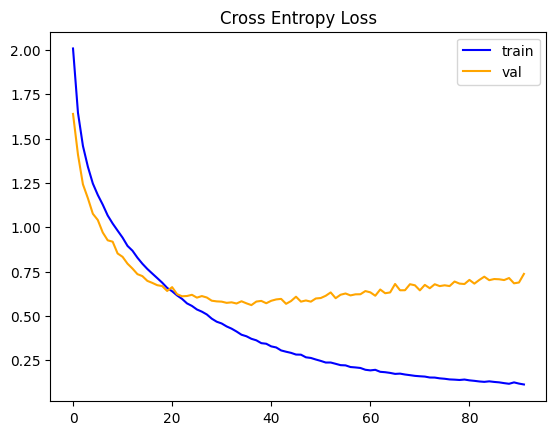

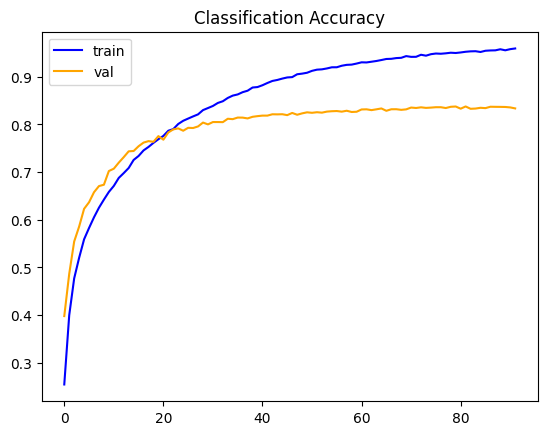

In [31]:
plt.title('Cross Entropy Loss')
plt.plot(history.history['loss'], color='blue', label='train')
plt.plot(history.history['val_loss'], color='orange', label='val')
plt.legend()
plt.show()

plt.title('Classification Accuracy')
plt.plot(history.history['accuracy'], color='blue', label='train')
plt.plot(history.history['val_accuracy'], color='orange', label='val')
plt.legend()
plt.show()

El coste podemos ver que es estable y es en el epoch 15 que se fija en un valor. Además la accuracy baila alrededor de 0.10. No se puede decir que sea un modelo muy bueno.

Veamos que tipo de predicciones estoy obteniendo sobre el conjunto de test (vamos a pintar las imagenes y sus clasificaciones)

In [32]:
predictions = model.predict(x_test)

313/313 [==============================] - 2s 5ms/step


Una de las ventajas de Python es que hay montones de funciones y código realizado por terceras personas. Aquí me he fusilado unas bonitas funciones (que he adaptado un poco a mis necesidades) para poder pintar las imagenes, su label (ground truth) y las clasificaciones que hemos realizado.

In [33]:
def plot_image(i, predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array, true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(predicted_label,
                                100*np.max(predictions_array),
                                true_label[0]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array, true_label[i]
  plt.grid(False)
  plt.xticks(range(10))
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label[0]].set_color('blue')

Dibujamos las primeras imagenes, con las predicciones y sus valores reales (un total de 20 imagenes, para no abusar de vuestros laptops)

Coloreamos las prediciones correctas en azul y los fallos en rojo. Aunque primero he impreso las etiquetas para que tengamos una referencia al grafico.

0 airplane
1 automobile
2 bird
3 cat
4 deer
5 dog
6 frog
7 horse
8 ship
9 truck


ValueError: ignored

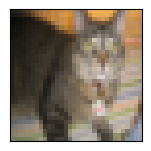

In [34]:
i = 0
for l in cifar10_labels:
    print(i, l)
    i += 1

num_rows = 5
num_cols = 4
start = 650
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i+start, predictions[i+start], y_test, x_test)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i+start, predictions[i+start], y_test)
plt.tight_layout()
plt.show()

## 7. Guardamos el modelo para futuras evaluaciones

Id cambiando los nombres del archivo para ir guardando los diversos proyectos.
Aquí lo guardamos en "local", pero recordad que lo ideal es que lo guardeis en Google Drive (teneis que montar la unidad, fijar la ruta y allí guardar el modelo .h5)

In [35]:
model.save('cifar10_base_model.h5')